# Veamos como usar Cross-Validation con MLP-CNN y medir la variabilidad del modelo con la varianza y visualizarla con los Boxplots.



In [21]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix


from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras import regularizers, utils
from keras.optimizers import SGD, RMSprop, Adam



In [22]:
N=10000
semilla1 = 23
n_classes = 5

noisy_data = sklearn.datasets.make_blobs(n_samples=N, n_features=2, centers=n_classes, cluster_std=3.0, random_state=semilla1)
#noisy_data = sklearn.datasets.make_moons(n_samples=N, noise=.40, random_state=semilla1) 
#noisy_data = sklearn.datasets.make_gaussian_quantiles(n_samples=N, n_features=2, n_classes=2, random_state=semilla1)  
#noisy_data = sklearn.datasets.make_circles(n_samples=N, noise=.20, random_state=semilla1, factor=0.7)  

In [23]:
X, Y = noisy_data

In [4]:
print(X.shape)
print(Y.shape)

(10000, 2)
(10000,)


In [29]:
print(Y[0:25])

[1 4 1 2 4 1 2 0 0 0 4 1 1 0 1 0 3 2 4 3 1 2 3 0 1]


In [30]:
# One-Hot encoding
Y_categ = utils.to_categorical(Y)

In [31]:
print(Y_categ.shape)

(10000, 5)


In [32]:
print(Y_categ[0:6])

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]


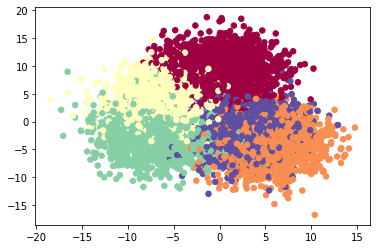

In [25]:
plt.scatter(X[:,0], X[:,1], c=Y, s=30, cmap=plt.cm.Spectral);

In [33]:
semilla2 = 17

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y_categ, train_size=.9, random_state=semilla2)        

In [11]:
print(X_train_val.shape)
print(Y_train_val.shape)
print(X_test.shape)
print(Y_test.shape)

(9000, 2)
(9000, 3)
(1000, 2)
(1000, 3)


###Puedes consultar más métodos de inicialización en:

https://www.tensorflow.org/api_docs/python/tf/keras/initializers

In [12]:
n_epochs = 20
n_neurons = 10 
n_batch = 32

lr = .01

n_folds = 10  # Este valor define el porcentaje de Train y Test. P.ej. si k=5, entonces se tiene 80% de Train y 20% de Test.

In [34]:
def mi_modelo():
  model = Sequential()

  model.add( Dense(units = n_neurons, input_dim=2, activation='tanh', kernel_initializer='identity') )  

  model.add( Dense(n_classes, activation='softmax') )

  opt = SGD(learning_rate =lr)
  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

In [35]:
mis_acc = []
mis_H = []
mejor_acc = 0 # inicializando el mejor acc

semilla3 = 31  #KFold

kf = KFold(n_folds, shuffle=True, random_state=semilla3)

for train_cvindex, val_cvindex in kf.split(X_train_val):   

  model = mi_modelo()
  
  trainX, trainY, valX, valY = X_train_val[train_cvindex], Y_train_val[train_cvindex], X_train_val[val_cvindex], Y_train_val[val_cvindex]

  History = model.fit(x=trainX, y=trainY, epochs=n_epochs, batch_size=n_batch, validation_data=(valX, valY), verbose=0)

  _, acc = model.evaluate(X_test, Y_test, verbose=0)
  print('> %.3f' % (acc * 100.0))

  mis_acc.append(acc)
  mis_H.append(History)

  if acc > mejor_acc:
    mejor_acc = acc
    mejor_modelo = model



> 76.900
> 75.800
> 76.600
> 75.700
> 75.300
> 76.000
> 75.100
> 75.700
> 76.700
> 76.300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


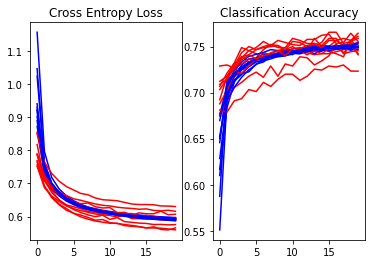

In [36]:
#def summarize_diagnostics(mis_H):
for i in range(len(mis_H)):
  # plot loss
  plt.subplot(121)
  plt.plot(mis_H[i].history['loss'], color='blue', label='train')
  plt.plot(mis_H[i].history['val_loss'], color='red', label='validation')
  plt.title('Cross Entropy Loss')

  # plot accuracy
  plt.subplot(122)
  plt.plot(mis_H[i].history['accuracy'], color='blue', label='train')
  plt.plot(mis_H[i].history['val_accuracy'], color='red', label='validation')
  plt.title('Classification Accuracy')

plt.show()

In [38]:
predictions = np.round(model.predict(X_test))

cm = confusion_matrix(Y_test.argmax(axis=1), predictions.argmax(axis=1))
total = sum(sum(cm))

accfin = 0
for i in range(n_classes):
  accfin += cm[i,i]

accfin /= total 

print(cm)
print("\nTest_Accuracy: {:.4f}".format(accfin))


[[181   0  21   0   4]
 [  7 159   0   0  50]
 [ 17   0 142  30   6]
 [  6   0  34 152   4]
 [ 19  44   4   6 114]]

Test_Accuracy: 0.7480


In [37]:
np.mean(mis_acc)*100

76.010000705719

In [39]:
np.std(mis_acc)*100

0.571751182454526

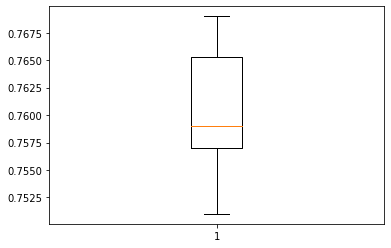

In [40]:
plt.boxplot(mis_acc)
plt.show()

In [41]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 55        
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________
